# Lorenz system: manifold plots

In [1]:
%matplotlib inline

import sys
import numpy as np
import matplotlib
import torch
import pickle
from tqdm import tqdm
from scipy.spatial import cKDTree

from matplotlib import pyplot as plt, cm
from matplotlib.collections import PolyCollection
from matplotlib.tri import Triangulation
from matplotlib.colors import LightSource
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from matplotlib.animation import FuncAnimation

sys.path.append("../../")
from experiments.datasets import LorenzSimulator
from experiments.architectures.vector_transforms import create_vector_transform
from manifold_flow.flows import ManifoldFlow
import plot_settings as ps


In [2]:
ps.setup()

## Options

In [3]:
mode = "sample"

## Load flows

In [ ]:
sim = LorenzSimulator(random_trajectories=10)


In [ ]:
def load_model(filename):
    outer_transform = create_vector_transform(
        3,
        5,
        linear_transform_type="permutation",
        base_transform_type="rq-coupling",
        context_features=None,
        dropout_probability=0.,
        tail_bound=3.,
        num_bins=5,
    )
    inner_transform = create_vector_transform(
        2,
        5,
        linear_transform_type="permutation",
        base_transform_type="rq-coupling",
        context_features=sim.parameter_dim(),
        dropout_probability=0.,
        tail_bound=3.,
        num_bins=5,
    )

    model = ManifoldFlow(
        data_dim=3,
        latent_dim=2,
        outer_transform=outer_transform,
        inner_transform=inner_transform,
        apply_context_to_outer=False,
    )
    
    model.load_state_dict(
        torch.load("../data/models/{}.pt".format(filename), map_location=torch.device("cpu"))
    )
    _ = model.eval()
    
    return model


mf = load_model("mf_2_lorenz_april2")


## Find points for evaluation: start with latent grid, triangulate, add points randomly where necessary, remove duplicates

In [ ]:
def make_grid(boundary, res):
    grid_each = np.linspace(-boundary, boundary, res)
    x, y = np.meshgrid(grid_each, grid_each)
    xy = np.vstack((x.flatten(), y.flatten())).T
    return xy


def make_lines(boundary, high_res, low_res):
    grid_high = np.linspace(-boundary, boundary, high_res)
    grid_low = np.linspace(-boundary, boundary, low_res)
    
    x, y = np.meshgrid(grid_high, grid_low)
    xy1 = np.vstack((x.flatten(), y.flatten())).T.reshape((5, 100, 2))
    
    x, y = np.meshgrid(grid_low, grid_high)
    xy2 = np.transpose(np.vstack((x.flatten(), y.flatten())).T.reshape((100, 5, 2)), [1, 0, 2])
    
    return list(xy1) + list(xy2)


def decode(zs, batchsize = 10000):
    xs = []
    n_batches = (len(zs) - 1) // batchsize + 1
    for i in range(n_batches):
        z_batch = zs[i*batchsize:(i+1)*batchsize]
        z_ = torch.tensor(z_batch, dtype=torch.float)
        x_ = mf.decode(u=z_)
        xs += list(x_.detach().numpy().flatten())

    xs = np.array(xs).reshape((-1, 3))
    return xs


def encode(xs, batchsize = 10000):
    zs = []
    n_batches = (len(xs) - 1) // batchsize + 1
    for i in range(n_batches):
        x_batch = xs[i*batchsize:(i+1)*batchsize]
        x_ = torch.tensor(x_batch, dtype=torch.float)
        z_ = mf.encode(x_)
        zs += list(z_.detach().numpy().flatten())

    zs = np.array(zs).reshape((-1, 2))
    return zs


def triangle_circumference(a, b, c):
    ab = np.linalg.norm(a - b)
    bc = np.linalg.norm(b - c)
    ca = np.linalg.norm(c - a)
    circ = (ab + bc + ca)
    return circ


def triangle_area(a, b, c):
    ab = np.linalg.norm(a - b)
    bc = np.linalg.norm(b - c)
    ca = np.linalg.norm(c - a)
    s = (ab + bc + ca) / 2.
    return (s * (s-ab) * (s-bc) * (s-ca))**0.5
    
    
def uniform_points_in_triangle(a, b, c, n=1):
    p = np.random.uniform(size=n)[:,np.newaxis]
    q = np.random.uniform(size=n)[:,np.newaxis]
    p_ = np.where(p + q > 1., 1. - p, p)
    q_ = np.where(p + q > 1., 1. - q, q)
    points = a[np.newaxis, :] + (b - a)[np.newaxis, :] * p_ + (c - a)[np.newaxis, :] * q_
    return points


In [ ]:
def iterate(xs, zs, goal_area = 0.01, goal_circ=0.2, insert_max=20, max_distance=0.1, distance_space="mix"):
    print("Beginning iteration")
    n_in = xs.shape[0]
    z_outs = np.copy(zs)
    
    # Step one: inserting more points where distances are large
    if insert_max > 0:
        # print("Triangulating...")
        triangulation = Triangulation(zs[:,0], zs[:,1])

        # print("Inserting points in latent space...")
        for t in triangulation.triangles:
            area = triangle_area(xs[t[0]], xs[t[1]], xs[t[2]])
            circ = triangle_circumference(xs[t[0]], xs[t[1]], xs[t[2]])
            try:
                n_additional = int(round(np.clip(
                    0.5 * (area / goal_area + circ / goal_circ),
                    0., insert_max
                ), 0))
            except:
                n_additional = insert_max // 2  # Seems like a safe choice

            if n_additional > 0:
                z_additional = uniform_points_in_triangle(
                    zs[t[0]],
                    zs[t[1]],
                    zs[t[2]],
                    n=n_additional
                )
                z_outs = np.concatenate((z_outs, z_additional), axis=0)

        #print("Decoding...")
        x_outs = decode(z_outs)
    else:
        x_outs = np.copy(xs)
    n_mid = len(x_outs)

    # Step two: removing close neighbors in (x,z) space
    if max_distance > 0.:
        #print(f"Looking for close neighbors in {distance_space} space...")
        if distance_space == "mix":
            tree = cKDTree(np.concatenate([x_outs, z_outs], axis=1))
        elif distance_space == "x":
            tree = cKDTree(z_outs)
        elif distance_space == "z":
            tree = cKDTree(z_outs)
        else:
            raise ValueError(distance_space)

        # print(f"Removing near-duplicates...")
        neighbors = tree.query_pairs(r=max_distance)
        duplicates = [n[1] for n in neighbors]

        x_outs = np.array([x for i, x in enumerate(x_outs) if i not in duplicates])
        z_outs = np.array([z for i, z in enumerate(z_outs) if i not in duplicates])
    n_out = len(x_outs)
    
    print(f"Done! {n_in} -> {n_mid} -> {n_out}")

    return x_outs, z_outs

In [ ]:
if mode == "latent":
    z_mf = make_grid(2.9, 100)
    x_mf = decode(z_mf)
    
    for _ in range(2):
        x_mf, z_mf = iterate(x_mf, z_mf)
        
elif mode == "mix":
    x_mf = sim.sample(1000)
    z_mf = encode(x_mf)
    
    for _ in range(2):
        x_mf, z_mf = iterate(x_mf, z_mf)
        
elif mode == "sample":
    x_mf = []
    z_mf = []
    for j in range(100):
        print(f"Starting round {j+1} / 100")
        x_ = sim.sample(4000)
        z_ = encode(x_)
        x_, z_ = iterate(x_, z_, insert_max=0, distance_space="x", max_distance=0.1)
        x_mf.append(x_)
        z_mf.append(z_)
        
    x_mf = np.concatenate(x_mf, axis=0)
    z_mf = np.concatenate(z_mf, axis=0)


In [ ]:
z_lines = make_lines(2.0, 100, 5)
x_lines = [decode(z) for z in z_lines]

## Evaluate log likelihood

In [ ]:
batchsize = 600
n_batches = (len(z_mf) - 1) // batchsize + 1

logps = []

for i in range(n_batches):
    print("Batch {} / {}".format(i + 1, n_batches))
    x_batch = x_mf[i*batchsize:(i+1)*batchsize]
    x_batch_ = torch.tensor(x_batch, dtype=torch.float)
    _, logp_, _ = mf(x_batch_, mode="mf")
    logps.append(logp_.detach().numpy().flatten())

logp_mf = np.hstack(logps)
logp_mf.shape


In [ ]:
x_traj = sim.trajectory(0)
z_traj = encode(x_traj, batchsize=10000)


## Save / load results

In [ ]:
# pickle.dump((x_mf, z_mf, logp_mf, x_traj, z_traj), open( "../data/results/lorenz_april2.pickle", "wb"))


In [4]:
x_mf, z_mf, logp_mf, x_traj, z_traj = pickle.load(open( "../data/results/lorenz_april2.pickle", "rb"))


## Scatter plots

In [5]:
logp_cutoff = -15.

cmin, cmax = -7., -2.
x_boundary = 3.

def cmap(vals):
    return ps.CMAP(np.clip((vals - cmin) / (cmax - cmin), 0., 1.))

if logp_cutoff is None:
    x_ = x_mf
    colors_ = cmap(logp_mf)
else:
    x_ = x_mf[logp_mf > logp_cutoff]
    colors_ = cmap(logp_mf[logp_mf > logp_cutoff])


In [ ]:
# Strongly based on https://discourse.matplotlib.org/t/trisurf-plots-with-independent-color-data/19033/2

plt.close("all")
fig, ax = ps.figure(height=0.33*ps.TEXTWIDTH, cbar=False, make3d=True, large_margin=0.01, small_margin=0.01)
    
ax.view_init(elev=20, azim=-70)  # Good front view
# ax.view_init(elev=20, azim=80)  # Another good view
# ax.view_init(elev=90, azim=0)  # Top-down view of x-y plane
# ax.view_init(elev=20, azim=60)  # Another good side view

ax.scatter(x_[:, 0], x_[:, 1], x_[:,2], c=colors_, s=1.0, marker="o", linewidths=0.)
# for x in x_lines:
#     ax.plot(x[:, 0], x[:, 1], x[:,2], c="black", lw=0.5, zorder=11)

ax.set_xlim3d(-2.8, 2.8)
ax.set_ylim3d(-2.8, 2.8)
ax.set_zlim3d(-2.8, 2.8)
ax.set_xticks([-2., 0., 2.])
ax.set_yticks([-2., 0., 2.])
ax.set_zticks([-2., 0., 2.])
ax.set_xticklabels(["-2\n", "0\n", "2\n"], va="center", ha="center", linespacing=2)  # arghgh
ax.set_yticklabels(["-2   \n", "0   \n", "2   \n"], ha="center", va="center", linespacing=2)
ax.set_zticklabels(["-2     ", "0     ", "2     "], ha="center")
ax.set_xlabel("$x_0$", labelpad=-5.)
ax.set_ylabel("$x_1$", labelpad=-5.)
ax.set_zlabel("$x_2$", labelpad=-5.)

plt.savefig("../figures/lorenz_model_front.png")


In [ ]:
plt.close("all")
fig, ax = ps.figure(height=0.33*ps.TEXTWIDTH, cbar=False, make3d=True, large_margin=0.01, small_margin=0.01)
    
ax.view_init(elev=20, azim=45)  # Great side view

thresholds = [-100., 0., 0.5, 1., 1.5, 2., 2.5, 100.]
prox = x_[:, 1] + x_[:, 0]
for zorder, (pmin, pmax) in enumerate(zip(thresholds[:-1], thresholds[1:])):
    filter_ = (prox >= pmin) & (prox < pmax)
    ax.scatter(
        x_[filter_][:, 0], x_[filter_][:, 1], x_[filter_][:,2],
        color=colors_[filter_], s=1.0, marker="o", linewidths=0., zorder=zorder
    )

# for x in x_lines:
#     ax.plot(x[:, 0], x[:, 1], x[:,2], c="black", lw=0.5, zorder=11)

ax.set_xlim3d(-2.8, 2.8)
ax.set_ylim3d(-2.8, 2.8)
ax.set_zlim3d(-2.8, 2.8)
ax.set_xticks([-2., 0., 2.])
ax.set_yticks([-2., 0., 2.])
ax.set_zticks([-2., 0., 2.])
ax.set_xticklabels(["-2\n", "0\n", "2\n"], va="center", ha="center", linespacing=2)  # arghgh
ax.set_yticklabels(["-2   \n", "0   \n", "2   \n"], ha="center", va="center", linespacing=2)
ax.set_zticklabels(["      -2", "       0", "       2"], ha="center")
ax.set_xlabel("$x_0$", labelpad=-5.)
ax.set_ylabel("$x_1$", labelpad=-5.)
ax.set_zlabel("$x_2$", labelpad=-8.)

plt.savefig("../figures/lorenz_model_side.png")


## Animated version

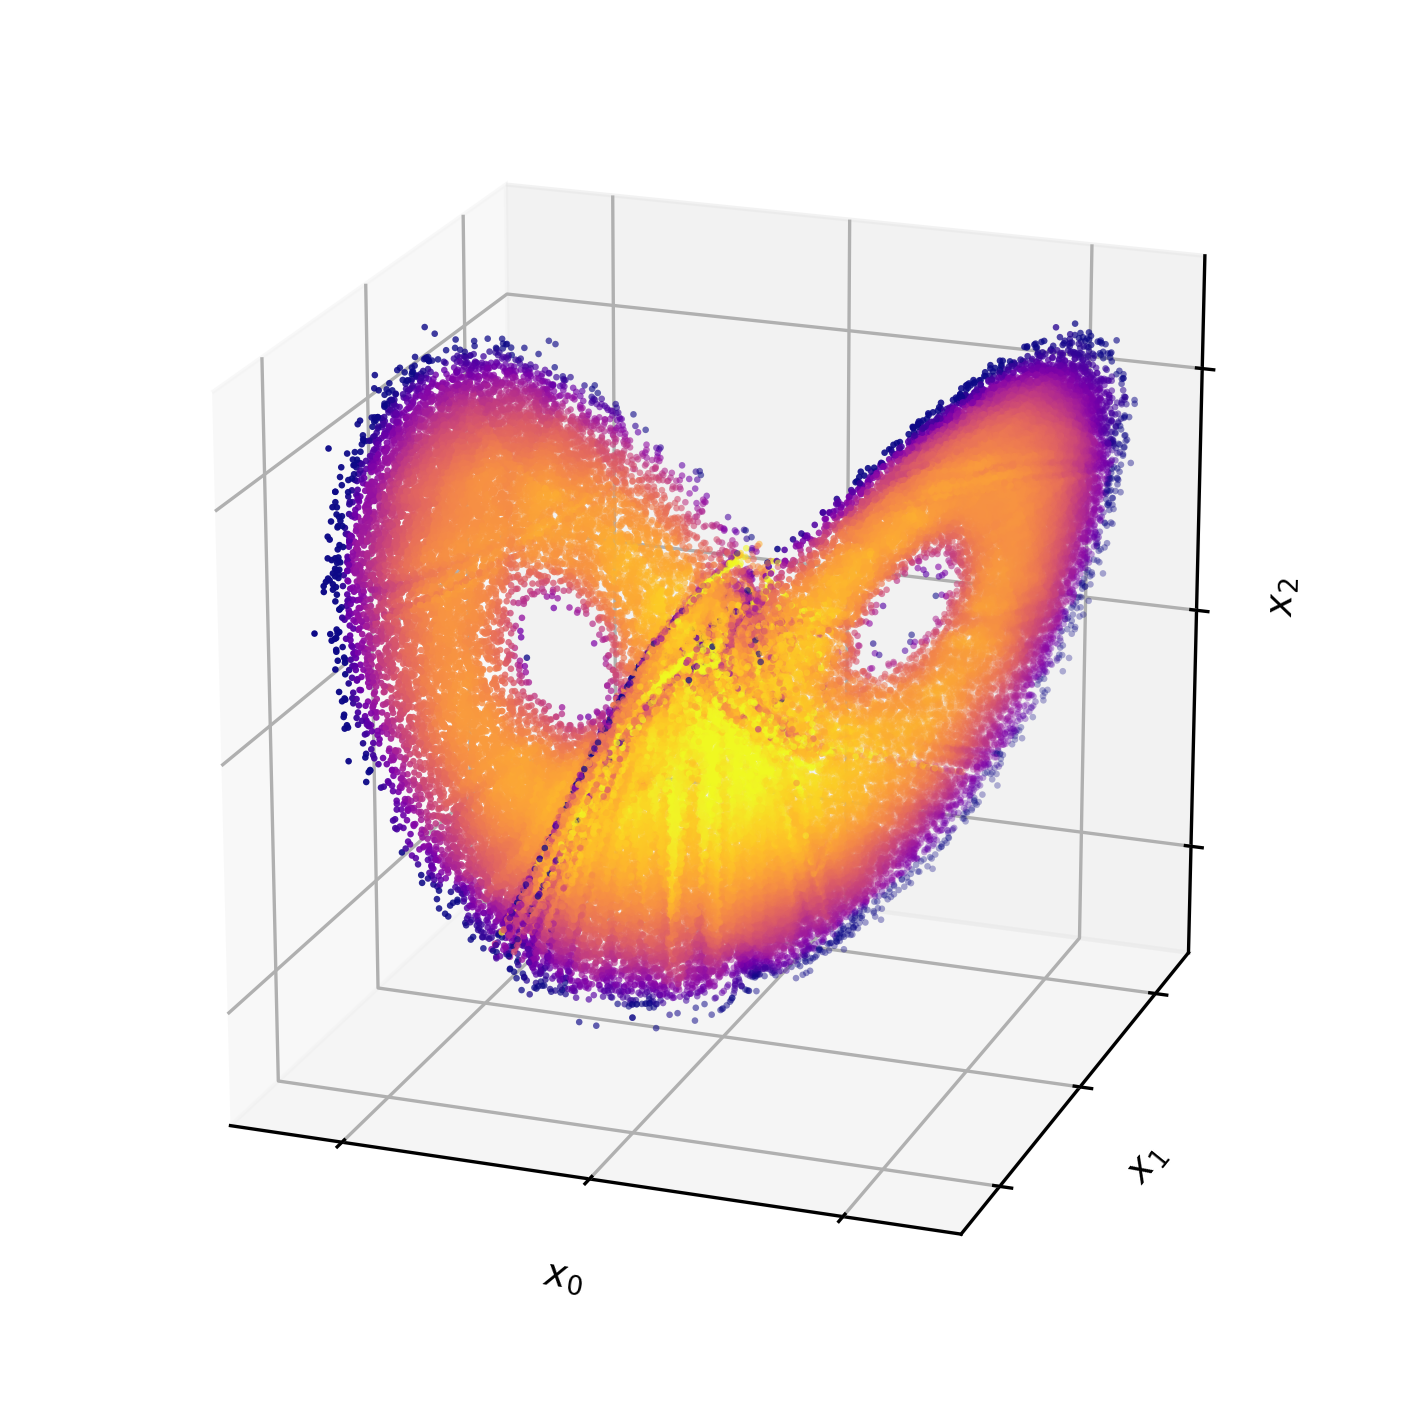

In [7]:
n_frames = 250
interval = 40

fig, ax = ps.figure(height=0.5*ps.TEXTWIDTH, cbar=False, make3d=True, large_margin=0.05, small_margin=0.05)
    
ax.view_init(elev=20, azim=-70)

ax.scatter(x_[:, 0], x_[:, 1], x_[:,2], c=colors_, s=2.5, marker="o", linewidths=0.)

ax.set_xlim3d(-2.8, 2.8)
ax.set_ylim3d(-2.8, 2.8)
ax.set_zlim3d(-2.8, 2.8)
ax.set_xticks([-2., 0., 2.])
ax.set_yticks([-2., 0., 2.])
ax.set_zticks([-2., 0., 2.])
ax.set_xticklabels(["", "", ""])
ax.set_yticklabels(["", "", ""])
ax.set_zticklabels(["", "", ""])
ax.set_xlabel("$x_0$", labelpad=-5.)
ax.set_ylabel("$x_1$", labelpad=-5.)
ax.set_zlabel("$x_2$", labelpad=-5.)

def update(t):
    ax.view_init(elev=20, azim=-70 + t * 360. / n_frames)

anim = FuncAnimation(fig, update, frames=np.arange(0, n_frames), interval=interval)
anim.save('../figures/lorenz_model.gif', dpi=100, writer='imagemagick')


## Triangulation

In [ ]:
# x_tri = []
# logp_tri = []
# z_tri = []
# minlogp_tri = []
# circ_tri = []

# x_ = x_mf
# z_ = z_mf
# logp_ = logp_mf

# tri = Triangulation(z_[:,0], z_[:,1])

# for t in tri.triangles:
#     z_tri.append(
#         [
#             [z_[t[0], 0], z_[t[0], 1]],
#             [z_[t[1], 0], z_[t[1], 1]],
#             [z_[t[2], 0], z_[t[2], 1]]
#         ]
#     )
#     x_tri.append(
#         [
#             [x_[t[0], 0], x_[t[0], 1], x_[t[0], 2]],
#             [x_[t[1], 0], x_[t[1], 1], x_[t[1], 2]],
#             [x_[t[2], 0], x_[t[2], 1], x_[t[2], 2]]
#         ]
#     )
#     logp_tri.append((logp_[t[0]] + logp_[t[1]] + logp_[t[2]]) / 3.)
#     minlogp_tri.append(min(logp_[t[0]], logp_[t[1]], logp_[t[2]]))
#     circ_tri.append(triangle_circumference(x_[t[0]], x_[t[1]], x_[t[2]]))

# z_tri = np.array(z_tri)
# x_tri = np.array(x_tri)
# logp_tri = np.array(logp_tri)
# minlogp_tri = np.array(minlogp_tri)
# circ_tri = np.array(circ_tri)

# logp_tri.shape, x_tri.shape, z_tri.shape, circ_tri.shape


## Preprocessing for plotting

In [ ]:
# logp_cutoff = -15.
# circ_cutoff = 1.2
# circ_cutoff2 = 5.
# cutoff2_applies_below_logp = -5.5

# cmin, cmax = -7., -2.
# x_boundary = 2.8

# def cmap(vals):
#     return ps.CMAP(np.clip((vals - cmin) / (cmax - cmin), 0., 1.))

# if logp_cutoff is None:
#     x_tri_ = x_tri
#     colors_tri_ = cmap(logp_tri)
#     z_tri_ = z_tri
#     circ_tri_ = circ_tri
#     logp_tri_ = logp_tri
# else:
#     x_tri_ = x_tri[minlogp_tri > logp_cutoff]
#     colors_tri_ = cmap(logp_tri[minlogp_tri > logp_cutoff])
#     z_tri_ = z_tri[minlogp_tri > logp_cutoff]
#     circ_tri_ = circ_tri[minlogp_tri > logp_cutoff]
#     logp_tri_ = logp_tri[minlogp_tri > logp_cutoff]

# if circ_cutoff2 is not None:
#     x_tri_ = x_tri_[(logp_tri_ > cutoff2_applies_below_logp) | (circ_tri_ < circ_cutoff2)]
#     colors_tri_ = colors_tri_[(logp_tri_ > cutoff2_applies_below_logp) | (circ_tri_ < circ_cutoff2)]
#     z_tri_ = z_tri_[(logp_tri_ > cutoff2_applies_below_logp) | (circ_tri_ < circ_cutoff2)]
#     logp_tri_save = logp_tri_[(logp_tri_ > cutoff2_applies_below_logp) | (circ_tri_ < circ_cutoff2)]
#     circ_tri_ = circ_tri_[(logp_tri_ > cutoff2_applies_below_logp) | (circ_tri_ < circ_cutoff2)]
#     logp_tri_ = logp_tri_save
    
# if circ_cutoff is not None:
#     x_tri_ = x_tri_[(logp_tri_ < cutoff2_applies_below_logp) | (circ_tri_ < circ_cutoff)]
#     colors_tri_ = colors_tri_[(logp_tri_ < cutoff2_applies_below_logp) | (circ_tri_ < circ_cutoff)]
#     z_tri_ = z_tri_[(logp_tri_ < cutoff2_applies_below_logp) | (circ_tri_ < circ_cutoff)]


## 2D plots for debugging

In [ ]:
# fig = plt.figure(figsize=(6,6))
# ax = plt.gca()

# coll = PolyCollection(z_tri_, facecolors=colors_tri_, edgecolors=colors_tri_, lw=0.5, rasterized=True)
# ax.add_collection(coll)

# # ax.plot(z_traj[:, 0], z_traj[:, 1], c="black", lw=0.5)

# plt.xlabel("$u_1$")
# plt.ylabel("$u_2$")

# plt.xlim(-3, 3)
# plt.ylim(-3, 3)

# plt.tight_layout()
# plt.savefig("../figures/lorenz_latent_likelihood.pdf")


In [ ]:
# def xcmap(vals):
#     return ps.CMAP(np.clip((vals - (-3)) / (3 - (-3)), 0., 1.))

# plt.close("all")
# fig = plt.figure(figsize=(12,4))

# for i in range(3):
#     ax = plt.subplot(1,3,i+1)
#     colors = xcmap(np.mean(x_tri_[:,:,i], axis=1))
#     coll = PolyCollection(z_tri_, facecolors=colors, edgecolors=colors, lw=0.5, rasterized=True)
#     ax.add_collection(coll)
#     plt.xlabel("$u_1$")
#     plt.ylabel("$u_2$")
#     plt.xlim(-3, 3)
#     plt.ylim(-3, 3)
#     plt.title(f"$x_{i+1}$", fontsize=11)

# plt.tight_layout()
# plt.savefig("../figures/lorenz_latent_x.pdf")


## 3D surface plot

In [ ]:
# # Strongly based on https://discourse.matplotlib.org/t/trisurf-plots-with-independent-color-data/19033/2

# plt.close("all")
# fig, ax = ps.figure(height=0.33*ps.TEXTWIDTH, cbar=False, make3d=True, large_margin=0.01, small_margin=0.01)
    
# coll = Poly3DCollection(x_tri_, facecolors=colors_tri_, edgecolors=colors_tri_, lw=0.5)
# ax.add_collection(coll)

# ax.set_xlim3d(-2.8, 2.8)
# ax.set_ylim3d(-2.8, 2.8)
# ax.set_zlim3d(-2.8, 2.8)
# ax.set_xticks([-2., 0., 2.])
# ax.set_yticks([-2., 0., 2.])
# ax.set_zticks([-2., 0., 2.])
# ax.set_xticklabels(["", "", ""])
# ax.set_yticklabels(["", "", ""])
# ax.set_zticklabels(["", "", ""])
# # ax.set_xticklabels(["-2\n", "0\n", "2\n"], va="center", ha="center", linespacing=2)  # arghgh
# # ax.set_yticklabels(["-2   \n", "0   \n", "2   \n"], ha="center", va="center", linespacing=2)
# # ax.set_zticklabels(["-2     ", "0     ", "2     "], ha="center")
# ax.set_xlabel("$x_0$", labelpad=-5.)
# ax.set_ylabel("$x_1$", labelpad=-5.)
# ax.set_zlabel("$x_2$", labelpad=-5.)

# ax.view_init(elev=20, azim=-70)  # Good front view
# plt.savefig("../figures/lorenz_likelihood_surface_front1.png")

# ax.view_init(elev=20, azim=80)  # Another good front view
# plt.savefig("../figures/lorenz_likelihood_surface_front2.png")

# ax.view_init(elev=20, azim=45)  # Good side view
# plt.savefig("../figures/lorenz_likelihood_surface_side1.png")

# ax.view_init(elev=20, azim=60)  # Another good side view
# plt.savefig("../figures/lorenz_likelihood_surface_side2.png")

# ax.view_init(elev=90, azim=0)  # Top-down view of x-y plane
# plt.savefig("../figures/lorenz_likelihood_surface_top.png")
